# Problem Set 3 (PS3): Probability of Profit Calculations using Lattice and Geometric Brownian Motion Models
PS3's objective is to explore the similarities and differences in the out-of-sample probability of profit calculations using two different model formulations: the binomial lattice model and the geometric Brownian motion model. In both cases, we'll use the parameter sets we've estimated using the `2018 -> 2023` data and then simulate `2024` data.
* This problem set __does not involve code development__. Instead, students will run this notebook for different hyper-parameter combinations and answer questions using the generated results.
* __Check__: A series of tests has been included at the bottom of the notebook to check your installation. These tests check the calculation results for the _default_ notebook parameters. If all is good with your setup, you should, by default, pass all tests.

### Learning objectives and tasks
* __Prerequisites__: Load and clean the testing dataset. Before we get started, we'll load the out-of-sample data, the previously estimated parameter sets and set some constants.
* __Task 1__: Build a collection of binomial lattice models. In this task, we'll build _empty_ lattice models for the assets in the out-of-sample dataset. We'll populate some particular lattice models in Task 3.
* __Task 2__: Build a collection of geometric Brownian motion models. In this task, we'll build geometric Brownian motion (GBM) models for the assets in the out-of-sample dataset. We'll populate some particular gbm models in Task 3.
* __Task 3__: Estimate the probability of profit using the different model types. In this task, we'll compute and compare the cumulative distribution curves, which we use to estimate the probability of profit, using lattice and gbm models.

Answer the questions in __Task 3__.

## Setup
We set up the computational environment by including [the `Include.jl` file](Include.jl). The [`Include.jl` file](Include.jl) loads external packages, various functions that we will use in the exercise, and custom types to model the components of our example problem.
* See the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl) for additional information on functions and types used in this material. 

In [3]:
include("Include.jl");

## Prerequisites: Load and clean the testing dataset

#### Out of Sample Data
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2024` until last week `09-23-24` close, along with data for a few exchange-traded funds and volatility products during that time. We load the `prediction_dataset` by calling the `MyOutOfSampleMarketDataSet()` function:

In [5]:
prediction_dataset = MyOutOfSampleMarketDataSet() |> x-> x["dataset"]

Dict{String, DataFrame} with 488 entries:
  "NI"   => 182×8 DataFrame…
  "EMR"  => 182×8 DataFrame…
  "CTAS" => 182×8 DataFrame…
  "HSIC" => 182×8 DataFrame…
  "KIM"  => 182×8 DataFrame…
  "PLD"  => 182×8 DataFrame…
  "IEX"  => 182×8 DataFrame…
  "BAC"  => 182×8 DataFrame…
  "CBOE" => 182×8 DataFrame…
  "EXR"  => 182×8 DataFrame…
  "NCLH" => 182×8 DataFrame…
  "CVS"  => 182×8 DataFrame…
  "DRI"  => 182×8 DataFrame…
  "DTE"  => 182×8 DataFrame…
  "ZION" => 182×8 DataFrame…
  "AVY"  => 182×8 DataFrame…
  "EW"   => 182×8 DataFrame…
  "EA"   => 182×8 DataFrame…
  "NWSA" => 182×8 DataFrame…
  "BBWI" => 182×8 DataFrame…
  "CAG"  => 182×8 DataFrame…
  "GPC"  => 182×8 DataFrame…
  "FCX"  => 182×8 DataFrame…
  "GILD" => 182×8 DataFrame…
  "UNP"  => 182×8 DataFrame…
  ⋮      => ⋮

Next, let's get a list of firms in the `prediction_dataset,` and save it in the `list_of_all_tickers::String` array:

In [7]:
list_of_all_tickers = keys(prediction_dataset) |> collect |> sort;

#### Lattice parameters
We saved the real-world and risk-neutral lattice parameter calculations, so let's load this save file to construct our lattice model. To load the `jld2` (binary) saved file, we pass the path to the file we want to load the [`load(...)` function](https://github.com/JuliaIO/FileIO.jl). This call returns the data as a [Julia `Dict` type](https://docs.julialang.org/en/v1/base/collections/#Base.Dict). 
* Let's set the path to the save file in the `path_to_lattice_save_file::String` variable.

In [9]:
path_to_lattice_save_file = joinpath(_PATH_TO_DATA, "L5a-RealWorldRiskNeutral-SavedData.jld2");

Then we load the `jld2` file using [the `load(...)` method](https://juliaio.github.io/FileIO.jl/stable/reference/#FileIO.load), where the contents of the file are stored in the `saved_data_dictionary::Dict{String, Any}` variable. 
* In particular, we pull out the `real_world_parameters::Dict{String, Tuple{Float64, Float64, Float64}}` dictionary that holds the real-world parameters estimated previously. This will have $(u,d,p)$ values for each ticker in the clean dataset.

In [11]:
saved_data_dictionary = load(path_to_lattice_save_file); # saved data as a dictionary
real_world_parameters = saved_data_dictionary["real_world_parameters"]

Dict{String, Tuple{Float64, Float64, Float64}} with 460 entries:
  "NI"   => (1.00888, 0.98974, 0.5428)
  "EMR"  => (1.01135, 0.988176, 0.525547)
  "CTAS" => (1.01068, 0.989279, 0.548772)
  "HSIC" => (1.01165, 0.987478, 0.526211)
  "KIM"  => (1.01443, 0.985488, 0.514267)
  "PLD"  => (1.0109, 0.988852, 0.53351)
  "IEX"  => (1.00984, 0.989644, 0.53351)
  "BAC"  => (1.013, 0.986732, 0.51493)
  "CBOE" => (1.00996, 0.989404, 0.532847)
  "EXR"  => (1.011, 0.989079, 0.522893)
  "NCLH" => (1.0251, 0.975189, 0.500332)
  "CVS"  => (1.01142, 0.988612, 0.506967)
  "DRI"  => (1.01405, 0.986421, 0.514267)
  "DTE"  => (1.0086, 0.990494, 0.53152)
  "ZION" => (1.01719, 0.98292, 0.504977)
  "AVY"  => (1.01164, 0.987978, 0.529529)
  "EW"   => (1.01274, 0.986972, 0.530192)
  "EA"   => (1.01135, 0.988119, 0.523557)
  "NWSA" => (1.01291, 0.987378, 0.511612)
  "CAG"  => (1.01029, 0.989518, 0.502322)
  "GILD" => (1.01021, 0.989964, 0.50365)
  "FCX"  => (1.02229, 0.979183, 0.504977)
  "GPC"  => (1.01038, 0.989

#### GBM parameters
Finally, we saved the estimated real-world GBM model parameters using data from 2018 to 2023, so let's load the saved parameter file to initialize our GBM model.
* Load the $(\hat{\mu},\hat{\sigma})$ dataset we computed previously [using `read(...)` method exported by the CSV.jl package](https://github.com/JuliaData/CSV.jl) and store this in the `parameters_df::DataFrame` variable. 

In [13]:
parameters_df = CSV.read(joinpath(_PATH_TO_DATA,"Parameters-SP500-2018-2023-Backup.csv"), DataFrame);

#### Constants
Let's set some constants we'll use later in this notebook. The comments describe the constants, the units, permissible values, etc.

In [15]:
Δt = (1.0/252); # step size: 1-trading day in units of years
risk_free_rate = 0.0; # hypothetical continuously compounding risk-free rate
simulation_start_index = 1; # start the first day of the OOS data
simulation_stop_index = 62; # end the last day of OOS data

## Task 1: Build a collection of binomial lattice models
In this task, we'll build a lattice model _for each asset_ in the `list_of_all_tickers::Array{String,1}`, i.e., for every ticker in the out-of-sample dataset. We'll store these models in the `lattice_model_dictionary::Dict{String, MyBinomialEquityPriceTree}` dictionary.

#### Strategy
* Iterate through each ticker in the `list_of_all_tickers::Array{String,1}` array, get the $(u,d,p)$ lattice parameters from the `parameters_df::Dict{String, Tuple{Float64, Float64, Float64}}` dictionary, and build [a `MyBinomialEquityPriceTree` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyBinomialEquityPriceTree) using [the appropriate `build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple{Type{MyBinomialEquityPriceTree},%20NamedTuple}). Do not populate the tree here; we'll populate the tree, i.e., compute the price and probability at each node below.
* __Note__: The out-of-sample data has additional tickers, so we'll only build models for which we have parameter data. In a lecture example, we've shown one way to do this. Alternatively, [check out the `haskey(...)` method](https://docs.julialang.org/en/v1/base/collections/#Base.haskey) which can be used to check if a dictionary has a key (this is the methods that we illustrate below).

In [17]:
lattice_model_dictionary = let

    lattice_model_dictionary = Dict{String, MyBinomialEquityPriceTree}(); # initialize storage
    for ticker ∈ list_of_all_tickers

        if (haskey(real_world_parameters, ticker) == true) # only build a model for which we have data

            # get lattice parameters
            u = real_world_parameters[ticker][1];
            d = real_world_parameters[ticker][2];
            p = real_world_parameters[ticker][3];

            # build -
            lattice_model_dictionary[ticker] = build(MyBinomialEquityPriceTree, (
                u = u, d = d, p = p));
        end
    end

    lattice_model_dictionary;
end;

Now that we the collection of lattice models, let's do something similar in spirit for the geometric Brownian motion models in task 2.

## Task 2: Build a collection of geometric Brownian motion models
In this task, we'll build geometric Brownian motion (GBM) models for the assets in the `list_of_all_tickers::Array{String,1}`, i.e., for every ticker in the out-of-sample dataset. We'll store these models in the `gbm_model_dictionary::Dict{String, MyGeometricBrownianMotionEquityModel}` dictionary.

#### Strategy
* Iterate through each ticker in the `list_of_all_tickers::Array{String,1}` array, get the $(\hat{\mu},\hat{\sigma})$ gbm parameters from the `parameters_df::Dict{String, DataFrame}` dictionary, and then build [a `MyGeometricBrownianMotionEquityModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyGeometricBrownianMotionEquityModel) using a [build function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple{Type{MyGeometricBrownianMotionEquityModel},%20NamedTuple}), where you pass in values for the $(\hat{\mu},\hat{\sigma})$ parameters as arguments to the [build function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple{Type{MyGeometricBrownianMotionEquityModel},%20NamedTuple}).
* __Note__: The out-of-sample data has additional tickers, so we'll only build models for which we have parameter data. Because the parameters are stored as [a DataFrame instance](https://dataframes.juliadata.org/stable/), where the first column is ticker symbols, we'll grab that column (as an array of strings) and use [the `in` method](https://docs.julialang.org/en/v1/base/collections/#Base.in) to check if have the ticker parameters.

In [20]:
gbm_model_dictionary = let

    gbm_model_dictionary = Dict{String, MyGeometricBrownianMotionEquityModel}(); # initialize storage
    training_ticker_list = parameters_df[:,:ticker]; # get's list of tickers in the training data set
    for ticker ∈ list_of_all_tickers

        if (ticker ∈ training_ticker_list) # only build a model for which we have data

            my_parameters = findfirst(x->x==ticker, parameters_df[:,:ticker]) |> i-> parameters_df[i,:];
            μ̂ = my_parameters[:drift]; # drift parameter
            σ̂ = my_parameters[:volatility]; # volatility parameter

            gbm_model_dictionary[ticker] = build(MyGeometricBrownianMotionEquityModel, (
                μ = μ̂, σ = σ̂ ));
        end
    end

    gbm_model_dictionary;    
end;

Now that we have both the lattice and gbm models, we can now compare probability of profit calculations for each model.

## Task 3: Estimate the probability of profit using the different model types
In this task, we'll compare the cumulative distribution curves, which we use to estimate the probability of profit, computed using a lattice model versus a gbm model. To start, let's specify a ticker (contained in both the training and out-of-sample prediction datasets) in the `my_ticker_of_interest::String` variable:

In [23]:
my_ticker_of_interest = "SPY"; # default is SPY, change this to look at different tickers

### Cumulative distribution lattice model
Next, we estimate the cumulative distribution function for the lattice model. To do this, we must first populate the lattice tree for `my_ticker_of_interest::String.`
* We populate a lattice model tree [using the `populate(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.populate-Tuple{MyBinomialEquityPriceTree}). We start the simulation on `simulation_start_index::Int64` and end on `simulation_stop_index::Int64`. We access the starting price of the asset of interest from the `prediction_dataset::Dict{String, DataFrame}.` Let's use the [volume weighted average price (vwap)](https://en.wikipedia.org/wiki/Volume-weighted_average_price) to initialize the tree.

In [25]:
populated_tree_model = let
    L = simulation_stop_index; # how many levels
    Sₒ = prediction_dataset[my_ticker_of_interest][simulation_start_index, :volume_weighted_average_price]; # start price
    model = lattice_model_dictionary[my_ticker_of_interest] |> model -> populate(model, Sₒ = Sₒ, h = L);
end;

Get the collection of nodes of [type `MyBiomialLatticeEquityNodeModel,`]() using the short-cut syntax `(tree::MyBinomialEquityPriceTree)(level::Int64)`, which returns the collection of nodes at `level = t.` Store the tree nodes at `level=simulation_stop_index` in the `leaves` array
* The short-cut syntax for accessing the tree nodes is equivalent to the command sequence: `tree.levels[level] .|> x-> tree.data[x].` If you'd like to see how we make a type callable, this logic is encoded in the [Compute.jl](src/Compute.jl) file. 

In [27]:
leaves = populated_tree_model(simulation_stop_index);

Now that we have computed the share price and the probability of the share price, we can sample the nodes of the binomial tree at `level=simulation_stop_index` using a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) initialized with the probability of each node at `level = simulation_stop_index.` 
* From this data, we can approximate the [cumulative distribution function](https://en.wikipedia.org/wiki/Cumulative_distribution_function) for the fractional return, i.e., the probability that the fractional return will be less than some specified (desired) value, i.e., breakeven.
* A [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) is a type of probability distribution that describes the possible outcomes of a random variable that can belong to one of `K` categories. In this case, the `K`-categories correspond to indexes of the nodes in the tree at `level = simulation_stop_index`
* Let's create a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) using the probabilities of our equity share prices on the leaves of the tree using the [Distributions.jl](https://github.com/JuliaStats/Distributions.jl) package. Save the [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) in the `dcat` variable.

In [29]:
leaf_probability_array = let
    
    leaf_probability_array = Array{Float64,1}();
    for leaf ∈ leaves
        p = leaf.probability;
        push!(leaf_probability_array,p);
    end
    leaf_probability_array;
end
dcat = Categorical(leaf_probability_array); # catagorical distribution for each node

Next, let's create the `minimum_return_target_array,` which holds the fractional returns calculated from the prices of the leaves of the binomial tree. 

In [31]:
minimum_return_target_array = let

    minimum_return_target_array = Array{Float64,1}();
    Sₒ = prediction_dataset[my_ticker_of_interest][simulation_start_index, :volume_weighted_average_price]; # start price
    for leaf ∈ leaves
        price = leaf.price;
        f = (price - Sₒ)/Sₒ;
        push!(minimum_return_target_array, f);
    end
    minimum_return_target_array;
end;

#### Estimate the cumulative distribution of the equity fractional return for the lattice
Finally, we let's draw `number_of_samples` from the categorical distribution `dcat` for each value in the `minimum_return_target_array` array to estimate the probability $P(X\leq{x})$ using [a `for-loop`](https://docs.julialang.org/en/v1/base/base/#for). 

For iteration of the loop, we:
* Specify a value for the `minimum_target_return,` i.e., this is the minimum level of return that we would accept.
* Next, initialize a counter variable `N₊ = 0` and generate `number_of_samples` values for the `random_state_index`, which points to a random category in our set of possible categories (leaves of the binomial tree).
* We get the fractional return for the random category, i.e., tree node, and store it in the `random_return_value` variable. We increment the counter variable if the `random_return_value<=minimum_target_return.`
* Finally, we estimate the `probability` of having `random_return_value<=minimum_target_return` by computing `N₊/number_of_samples.` We store this in the `length(karray)`$\times$`2` array `lattice_cumulative_distribution_array,` where the first column is the `minimum_target_return,` and the second column is the `probability.`

`Unhide` the code block below to see how we estimated $P(X\leq{x})$ for each element of the `minimum_return_target_array` array. We store these results in the `lattice_cumulative_distribution_array::Array{Float64,2}` variable, where each row corresponds to a different desired fractional return, the first column in the fractional return $x$, and the second column holds the $P(X\leq{x})$ values.

In [33]:
lattice_cumulative_distribution_array = let

    karray = range(0,simulation_stop_index,step = 1) |> collect; # numbering of nodes at L from top to bottom
    Sₒ = prediction_dataset[my_ticker_of_interest][simulation_start_index, :volume_weighted_average_price]; # start price
    number_of_samples = 25000; # number of samples that we draw from the distribution -
    cumulative_distribution_array = Array{Float64,2}(undef, length(karray), 2);
    
    for i ∈ eachindex(karray)
        
        minimum_target_return = minimum_return_target_array[i];
        
        N₊ = 0;
        for j ∈ 1:number_of_samples
            random_state_index = rand(dcat); #

            leaf = leaves[random_state_index];
            random_return_value = (leaf.price - Sₒ)/Sₒ
            if random_return_value <= minimum_target_return;
                N₊ += 1
            end
        end
        
        probability = N₊/number_of_samples;     
        cumulative_distribution_array[i,1] = minimum_target_return;
        cumulative_distribution_array[i,2] = probability;
    end

    cumulative_distribution_array;
end;

### Cumulative distribution for the GBM model
Estimate [the cumulative distribution function](https://en.wikipedia.org/wiki/Cumulative_distribution_function) for the fractional return, i.e., the scaled net present value for `2024` for `my_ticker_of_interest::String` using the GBM models. However, before we can do this, we need to sample the gbm model to produce a set of potential futures that we use to estimate the cumulative probability.

To simulate the GBM model, we need to specify the `number_of_samples,` i.e., the number of trajectories to compute, the initial share price `Sₒ,` the initial time `T₁,` the final time `T₂.` Pass these (along with your `model` instance) into the [sample function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyGeometricBrownianMotionEquityModel,%20NamedTuple}). 
* The [sample function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyGeometricBrownianMotionEquityModel,%20NamedTuple}) generates `number_of_samples` possible price trajectories from $T_{1}\rightarrow{T}_{2}$ using the GBM `model` instance. The simulation data is returned as an array, where the first column in the time and columns `2:end` hold simulated trajectories. Store this in the variable `X`

In [35]:
X = let 
    
    number_of_samples = 5000; # how many different futures should we simulate
    Sₒ = prediction_dataset[my_ticker_of_interest][simulation_start_index, :volume_weighted_average_price]; # start price
    model = gbm_model_dictionary[my_ticker_of_interest]; # get model from dictionary

    # setup times
    T₁ = (simulation_start_index - 1)*Δt # start at simulation_start_index
    T₂ = (simulation_stop_index - 1)*Δt # stop at simulation_stop_index
    
    # sample
    X = VLQuantitativeFinancePackage.sample(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt), 
        number_of_paths = number_of_samples);

    # return the X 
    X;
end;

Now that we have the samples matrix `X,` let's estimate the [the cumulative distribution function](https://en.wikipedia.org/wiki/Cumulative_distribution_function) for fractional return. We'll use the following strategy:
* __Strategy__: For each potential hypothetical future (specified by the `number_of_samples::Int64` variable), compute the fraction of these futures that are less than or equal to elements of the `minimum_return_target_array::Array{Float64,1}` array. This gives us an estimate of $P(X\leq{x})$. In the $P(X\leq{x})$ expression, big $X$ is a random value (observed fractional return), and $x$ is a specified value (desired fractional return).

`Unhide` the code block below to see how we estimated $P(X\leq{x})$ for each element of the `minimum_return_target_array` array. We store these results in the `gbm_cumulative_probability_array::Array{Float64,2}` variable, where each row corresponds to a different desired fractional return, the first column in the fractional return $x$ and the second column holds the $P(X\leq{x})$ values.

In [37]:
gbm_cumulative_probability_array = let

    number_of_samples = size(X,2) - 1; # first col is time
    number_of_test_points = length(minimum_return_target_array);
    cumulative_probability_array = Array{Float64,2}(undef, number_of_test_points, 2);
    for i ∈ eachindex(minimum_return_target_array)
        test_return = minimum_return_target_array[i];
    
        N₊ = 0; # How many positive examples do we have?
        for j ∈ 1:number_of_samples
            Sₒ = X[1,j+1]; # initial share price
            S = X[end,j+1]; # final price, col 1 is time
            estimate_fractional_return = (S - Sₒ)/Sₒ;

            # in this potential future, estimate_fractional_return ≤ test_return?
            if (estimate_fractional_return ≤ test_return)
                N₊ += 1;
            end
        end

        cumulative_probability_array[i,1] = test_return;
        cumulative_probability_array[i,2] = (N₊/number_of_samples);
    end

    cumulative_probability_array;
end;

### Visualize
`Unhide` the code block below to see how we plotted the estimated $P(X\leq{x})$ values for the lattice and gbm models. The blue line gives the estimated cumulative distribution for the GBM model. The red line gives the estimated cumulative distribution for the lattice model.
* To zoom in out on different regions of the curve, modify the `xlims` parameters in the `plot(...)` function.

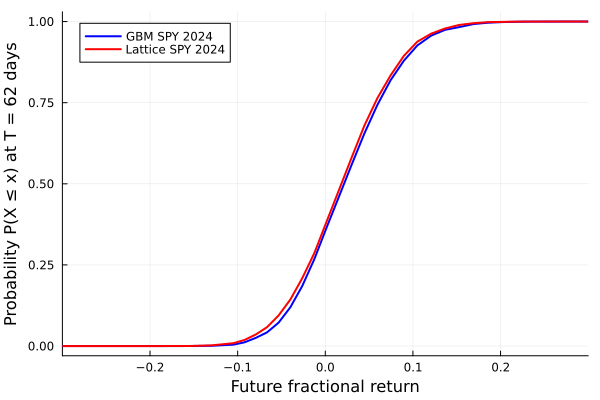

In [39]:
let
    plot(gbm_cumulative_probability_array[:,1], gbm_cumulative_probability_array[:,2], 
        c=:blue, lw=2, label="GBM $(my_ticker_of_interest) 2024", xlims=(-0.30,0.30));
    plot!(lattice_cumulative_distribution_array[:,1], lattice_cumulative_distribution_array[:,2], 
        c=:red, lw=2, label="Lattice $(my_ticker_of_interest) 2024");
    
    xlabel!("Future fractional return", fontsize=18)
    ylabel!("Probability P(X ≤ x) at T = $(simulation_stop_index) days", fontsize=18)
end

### Discussion
1. Simulate `JNJ,` or `GS.` The lattice model cumulative distribution curve _leads_ the GBM model, i.e., the estimated cumulative distribution for the lattice model is shifted to the left of the GBM model (for `SPY,` the curves are more similar). What does this mean for the estimated break-even probability? Do you think this feature has any other significance? 

In [41]:
# Fill me in for Q1.

2. Simulate `NVDA,` `MU` or `AMD.` The cumulative distribution curves for these tickers intersect, with the GBM curve initially leading and the lattice model curve having a sharper transition. What is the significance to the break-even probability? Further, do the sharper, more step-like features shown by the lattice model have any other significance?

In [43]:
# Fill me in for Q2

## Testing
In the code block below, we compare your answers to the teaching team and give you feedback on which items are the same (which presumably means they are correct) and which are different. `Unhide` the code block below (if you are curious) about how we implemented the tests and what we are testing.

In [45]:
# let
#     path_to_soln_file = joinpath(_PATH_TO_SOLN, "PS3-TeachingTeam-Solution-CHEME-5660-Fall-2024.jld2"); # set the path to the solution file

#     # write the solution file
#     save(path_to_soln_file, Dict("lattice_model_dictionary" => lattice_model_dictionary, 
#             "gbm_model_dictionary"=> gbm_model_dictionary,
#             "leaf_probability_array" => leaf_probability_array,
#             "minimum_return_target_array" => minimum_return_target_array, 
#             "leaves" => leaves, "simulation_start_index" => simulation_start_index, 
#             "simulation_stop_index" => simulation_stop_index, "Δt" => Δt,
#             "my_ticker_of_interest" => my_ticker_of_interest));
# end

__Note__: The checks below will execute for the default settings. As you change the parameters to answer the discussion questions, these will not execute. 

In [47]:
let
    # load teaching team solution data -
    saved_solution_dict = joinpath(_PATH_TO_SOLN,"PS3-TeachingTeam-Solution-CHEME-5660-Fall-2024.jld2") |> load;

    if (simulation_stop_index == 62 && my_ticker_of_interest == "SPY")
        @testset verbose = true "PS3 Test Suite" begin
            @testset "checking problem setup" begin
                ticker_soln = saved_solution_dict["my_ticker_of_interest"];
                simulation_start_index_soln = saved_solution_dict["simulation_start_index"];
                simulation_stop_index_soln = saved_solution_dict["simulation_stop_index"];
                Δt_soln = saved_solution_dict["Δt"];
    
                @test ticker_soln == my_ticker_of_interest
                @test simulation_start_index_soln == simulation_start_index;
                @test simulation_stop_index_soln == simulation_stop_index;
                @test Δt_soln == Δt
            end

            @testset "checking lattice model setup" begin
                lattice_model_dictionary_soln = saved_solution_dict["lattice_model_dictionary"];
            
                # check: SPY -
                @test lattice_model_dictionary_soln["SPY"].u == lattice_model_dictionary["SPY"].u
                @test lattice_model_dictionary_soln["SPY"].d == lattice_model_dictionary["SPY"].d
                @test lattice_model_dictionary_soln["SPY"].p == lattice_model_dictionary["SPY"].p
            end

            @testset "checking gbm model setup" begin
                gbm_model_dictionary_soln = saved_solution_dict["gbm_model_dictionary"];
            
                # check: SPY -
                @test gbm_model_dictionary_soln["SPY"].μ == gbm_model_dictionary["SPY"].μ
                @test gbm_model_dictionary_soln["SPY"].σ == gbm_model_dictionary["SPY"].σ   
            end

            @testset "checking lattice leaf probability values" begin
                leaf_probability_array_soln = saved_solution_dict["leaf_probability_array"];
                for i ∈ eachindex(leaf_probability_array_soln)
                    @test isapprox(leaf_probability_array_soln[i], leaf_probability_array[i]) 
                end
            end

             @testset "checking lattice leaf price values" begin
                leaves_soln = saved_solution_dict["leaves"];
                for i ∈ eachindex(leaves_soln)
                    @test isapprox(leaves_soln[i].price, leaves[i].price) 
                end
            end
        end
    else
        println("Parameters changed: tests are disabled. Reset to default settings to run tests.")
    end
end;

Test Summary:                              | Pass  Total  Time
PS3 Test Suite                             |  135    135  0.1s
  checking problem setup                   |    4      4  0.1s
  checking lattice model setup             |    3      3  0.0s
  checking gbm model setup                 |    2      2  0.0s
  checking lattice leaf probability values |   63     63  0.0s
  checking lattice leaf price values       |   63     63  0.0s


## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.